In [5]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [6]:
def make_square(image):
    height, width = image.shape[0], image.shape[1]
    size = max(height, width)
    top = bottom = int((size - height) / 2)
    left = right = int((size - width) / 2)
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value = [0, 0, 0])
    return new_image

In [7]:
cwd = os.getcwd()
path_input = cwd + "/dataset/input"
path_output = cwd + "/dataset/output"

In [8]:
# Original Dimensions for train
N = 500
image_width = 480
image_height = 480
channels = 3
ratio = 1

image_width = int(image_width / ratio)
image_height = int(image_height / ratio)
dimension = (image_width, image_height)

i = 0

X = np.ndarray(shape = (N, image_height, image_width), dtype = np.float32)
Y = np.ndarray(shape = (N, image_height, image_width, channels), dtype = np.float32)

for filename in sorted(os.listdir(path_input)):
    if filename.endswith(".jpg"):
        image_input = cv2.imread(path_input + "/" + filename, cv2.IMREAD_UNCHANGED)
        image_input = make_square(image_input)
        image_input = cv2.resize(image_input, dimension, interpolation = cv2.INTER_NEAREST)
        image_input = np.array(np.asarray(image_input))
        
        image_output = cv2.imread(path_output + "/" + filename, cv2.IMREAD_UNCHANGED)
        image_output = make_square(image_output)
        image_output = cv2.resize(image_output, dimension, interpolation = cv2.INTER_NEAREST)
        image_output = np.array(np.asarray(image_output))
        
        X[i] = image_input
        Y[i] = image_output
        i += 1
        
        if i % 100 == 0:
            print(str(i) + " images are done!")
    else:
        continue

100 images are done!
200 images are done!
300 images are done!
400 images are done!
500 images are done!


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 13)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.125, random_state = 13)
print("Train set size: {0}, Val set size: {1}, Test set size: {2}".format(len(X_train), len(X_val), len(X_test)))
print("X_train shape: {0}, X_val shape: {1}, X_test shape: {2}".format(X_train.shape, X_val.shape, X_test.shape))
print("Y_train shape: {0}, Y_val shape: {1}, Y_test shape: {2}".format(Y_train.shape, Y_val.shape, Y_test.shape))

Train set size: 350, Val set size: 50, Test set size: 100
X_train shape: (350, 480, 480), X_val shape: (50, 480, 480), X_test shape: (100, 480, 480)
Y_train shape: (350, 480, 480, 3), Y_val shape: (50, 480, 480, 3), Y_test shape: (100, 480, 480, 3)


In [13]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def conv2d(x, W):
    return tf.nn.conv2d(input = x, filter = W, strides = [1, 1, 1, 1], padding = "SAME")

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")

In [15]:
# 481 * 481: padding = "SAME", stride = 1
# d_wconv1: filter size = 3
# d_bconv1: 

def discriminator(x_image, reuse=False):
    with tf.variable_scope("discriminator") as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
            
        # First Conv Layers
        W_conv1 = tf.get_variable(name = 'd_wconv1', shape = [3, 3, 1, 8], 
                                  initializer = tf.truncated_normal_initializer(stddev = 0.02))
        b_conv1 = tf.get_variable(name = 'd_bconv1', shape = [8], 
                                  initializer=tf.constant_initializer(0))
        h_conv1 = tf.nn.relu(conv2d(X_train, W_conv1) + b_conv1)
        
        # Second Conv Layers
        W_conv2 = tf.get_variable(name = "d_wconv2", shape = [3, 3, 8, 16], 
                                  initializer = tf.truncated_normal_initializer(stddev = 0.02))
        b_conv2 = tf.get_variable(name = 'd_bconv2', shape = [16], 
                                  initializer=tf.constant_initializer(0))
        h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)
        
        '''
        # Third Conv Layers
        W_conv3 = tf.get_variable(name = "d_wconv3", shape = [3, 3, 16, 32], 
                                  initializer = tf.truncated_normal_initializer(stddev = 0.02))
        b_conv3 = tf.get_variable(name = 'd_bconv3', shape = [32], 
                                  initializer=tf.constant_initializer(0))
        h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3) + b_conv3)
        '''
        
        # First Pool Layers: 240 * 240 * 16
        h_pool1 = avg_pool_2x2(h_conv2)
        
        # Second Pool Layers: 120 * 120 * 16
        h_pool2 = avg_pool_2x2(h_pool1)
        
        # Third Pool Layers: 60 * 60 * 16
        h_pool3 = avg_pool_2x2(h_pool2)
        
        # Fourth Pool Layers: 30 * 30 * 16
        h_pool4 = avg_pool_2x2(h_pool3)
        
        # Fifth Pool Layers: 15 * 15 * 16
        h_pool5 = avg_pool_2x2(h_pool4)
        
        # First Fully Connected Layer
        W_fc1 = tf.get_variable(name = "d_wfc1", shape = [15 * 15 * 16, 32], 
                                initializer = tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable(name = "d_bfc1", shape = [32], 
                                initializer = tf.constant_initializer(0))
        h_pool5_flat = tf.reshape(h_pool5, [-1, 15 * 15 * 16])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool5_flat, W_fc1) + b_fc1)
        
        # Second Fully Connected Layer
        W_fc2 = tf.get_variable(name = "d_wfc2", shape = [32, 1], 
                                initializer = tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable(name = "d_bfc2", shape = [1], 
                                initializer = tf.constant_initializer(0))

        #Final Layer
        y_conv = (tf.matmul(h_fc1, W_fc2) + b_fc2)
        
        
        '''
        #Second Conv and Pool Layers
        W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)

        #First Fully Connected Layer
        W_fc1 = tf.get_variable('d_wfc1', [7 * 7 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*16])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        #Final Layer
        y_conv=(tf.matmul(h_fc1, W_fc2) + b_fc2)
        '''
    return y_conv

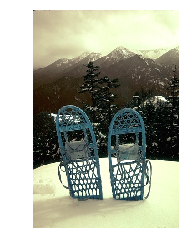

In [19]:
def generator(z, batch_size, z_dim, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
            
        g_dim = 64 # Number of filters of first layer of generator 
        c_dim = 3 # Color dimension of output
        s = 480 # Output size of the image
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16) #We want to slowly upscale the image, so these values will help
                                                                  #make that change gradual
        # dimension of z = batch_size x 480 x 480 x 3
        input_shape = z.shape
        
        # first conv layer + pool layer: 240 x 240 x 32
        output1_shape = (batch_size, s2, s2, 32)
        
        W_conv1 = tf.get_variable("g_wconv1", [3, 3, 1, 32],
                                  initializer = tf.truncated_normal_initializer(stddev = 0.1))
        b_conv1 = tf.get_variable("g_bconv1", [output1_shape[-1]], 
                                  initializer = tf.constant_initializer(0)) # initializer = tf.truncated_normal_initializer(stddev = 0.1))
        h_conv1 = tf.nn.relu(conv2d(z, W_conv1) + b_conv1)
        h_pool1 = avg_pool_2x2(h_conv1)
        
        # second conv layer + pool layer: 120 x 120 x 64
        output2_shape = (batch_size, s4, s4, 64)
        
        W_conv2 = tf.get_variable("g_wconv2", [3, 3, 32, 64],
                                  initializer = tf.truncated_normal_initializer(stddev = 0.1))
        b_conv2 = tf.get_variable("g_bconv2", [output2_shape[-1]], 
                                  initializer = tf.constant_initializer(0)) # initializer = tf.truncated_normal_initializer(stddev = 0.1))
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)
        
        # third conv layer + pool layer: 60 x 60 x 128
        output3_shape = (batch_size, s8, s8, 128)
        
        W_conv3 = tf.get_variable("g_wconv3", [3, 3, 64, 128],
                                  initializer = tf.truncated_normal_initializer(stddev = 0.1))
        b_conv3 = tf.get_variable("g_bconv3", [output3_shape[-1]], 
                                  initializer = tf.constant_initializer(0)) # initializer = tf.truncated_normal_initializer(stddev = 0.1))
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
        h_pool1 = avg_pool_2x2(h_conv1)
        
        # fourth conv layer + pool layer: 30 x 30 x 256
        output1_shape = (batch_size, s16, s16, 256)
        
        W_conv4 = tf.get_variable("g_wconv4", [3, 3, 128, 256],
                                  initializer = tf.truncated_normal_initializer(stddev = 0.1))
        b_conv4 = tf.get_variable("g_bconv4", [output4_shape[-1]], 
                                  initializer = tf.constant_initializer(0)) # initializer = tf.truncated_normal_initializer(stddev = 0.1))
        h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
        h_pool4 = avg_pool_2x2(h_conv4)
        
        
        
        
        
        h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25])
        h0 = tf.nn.relu(h0)
        #Dimensions of h0 = batch_size x 2 x 2 x 25

        #First DeConv Layer
        output1_shape = [batch_size, s8, s8, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv1
        H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        #Dimensions of H_conv1 = batch_size x 3 x 3 x 256

        #Second DeConv Layer
        output2_shape = [batch_size, s4 - 1, s4 - 1, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv2
        H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        #Dimensions of H_conv2 = batch_size x 6 x 6 x 128

        #Third DeConv Layer
        output3_shape = [batch_size, s2 - 2, s2 - 2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv3
        H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        #Dimensions of H_conv3 = batch_size x 12 x 12 x 64

        #Fourth DeConv Layer
        output4_shape = [batch_size, s, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, 
                                         strides=[1, 2, 2, 1], padding='VALID') + b_conv4
        H_conv4 = tf.nn.tanh(H_conv4)
        #Dimensions of H_conv4 = batch_size x 28 x 28 x 1

    return H_conv4

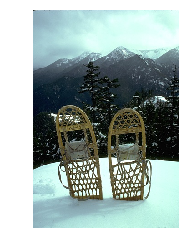

In [18]:
image = Image.open("dataset/2018.jpg")
plt.axis("off")
plt.imshow(image)
plt.show()